# Résultats des analyses sur Annonceur1_campagne4_visite_2pages

Nous présentons ici les résultats graphiques et leur analyse pour la campagne mentionnée.

In [1]:
import pandas as pd
from premiere_analyse import *
from testZ import *
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("white")

import numpy as np
import scipy.stats as st
%load_ext autoreload
%autoreload 2

In [2]:
#données de la campagne
# folder = 'C:/Users/Admin/Documents/Centrale Paris/3A/OMA/Projet/Donnees/'
folder = 'Data/'
annonceur = 'annonceur1/annonceur1'
campagne = 'annonceur1_campaign4_visite_2pages'
data = pd.read_hdf(folder + annonceur + '.hdf', key=campagne)

Analyse du taux de conversion des versions A et B de la bannière en tant que série temporelle

In [3]:
#préparation des données
dataA, dataB = preparer(data) 

Conversion des index en dates
Moyennes des taux par jour et séparation en deux groupes A et B


La moyenne du taux de conversion pour les 2 groupes est très similaire :

In [4]:
data.groupby('group')['is_conv'].mean()

group
A    0.001025
B    0.001006
Name: is_conv, dtype: float64

# Visualisation des données brutes

Est-ce qu'il y a un pattern (journalier, hebdomadaire, mensuel, ...) dans le taux de conversion ou la différence relative de taux de conversion ? 

On ajoutera aussi le nombre total de conversions pour la fréquence donnée afin de savoir si une importante différence relative est significative ou pas (si c'est 100% mais pour un 1 vs 2 par exemple).

In [5]:
freq_list = ["1D", "1W"]

conv_rate = {}
pct_change = {}
conv_count = {}

for freq in freq_list:
    conv_count[freq] = conversion_count_resample(data, freq)
    conv_rate[freq] = conversion_rate_resample(data, freq)
    pct_change[freq] = (conv_rate[freq]["A"] - conv_rate[freq]["B"]) / conv_rate[freq]["B"]
    # attention il y a des NaN quand il y a pas de conversion du groupe B

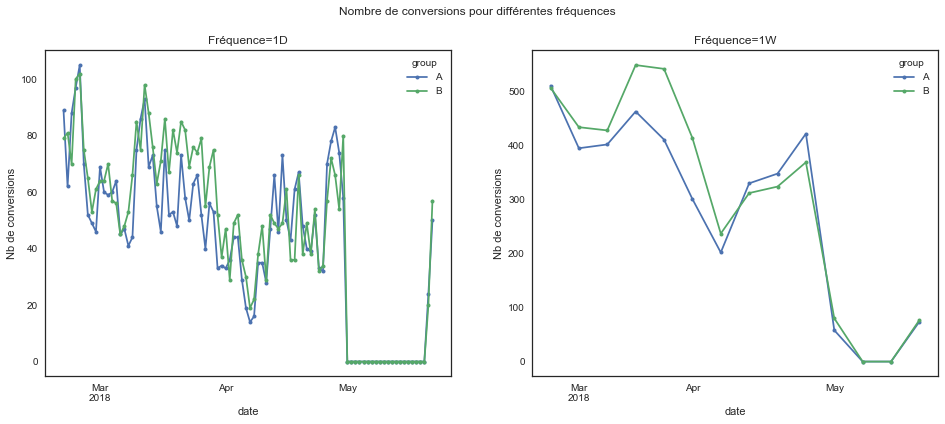

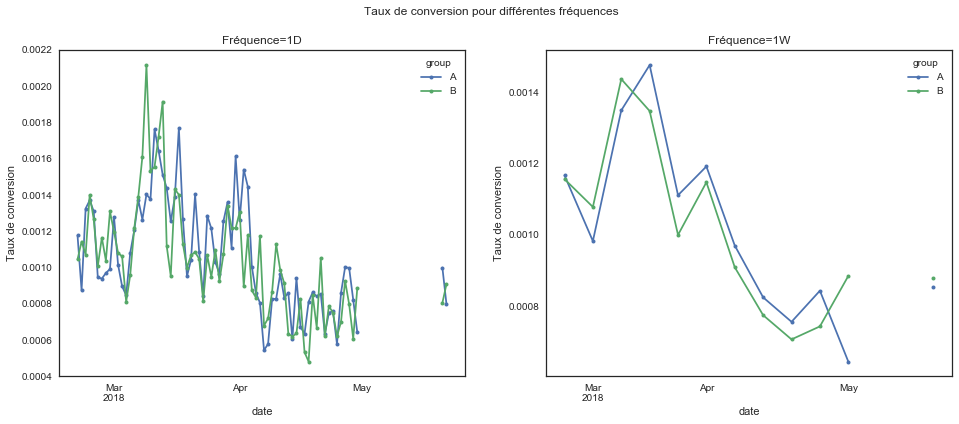

In [6]:
# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_count[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Nb de conversions')
plt.suptitle('Nombre de conversions pour différentes fréquences')
plt.show()

# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_rate[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Taux de conversion')
plt.suptitle('Taux de conversion pour différentes fréquences')
plt.show()

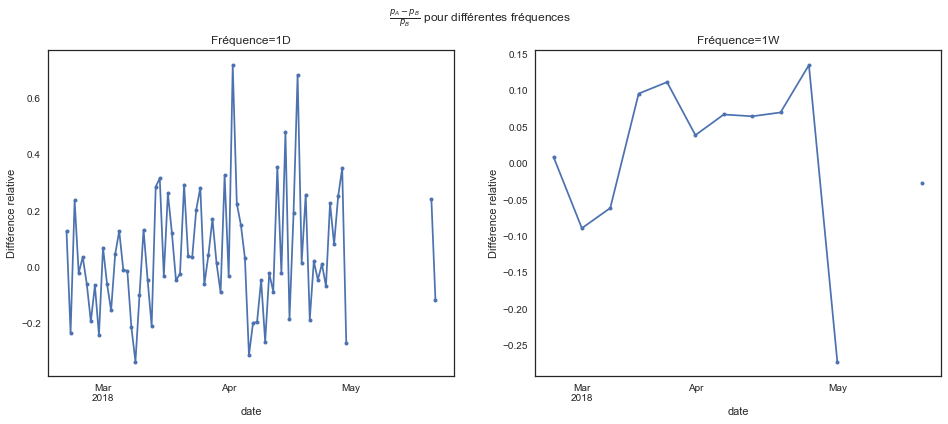

In [7]:
# trace des variations relatives pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    pct_change[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Différence relative')
plt.suptitle('$\\frac{p_A - p_B}{p_B}$ pour différentes fréquences')
plt.show()

Dans l'ensemble il n'y a pas de tendance marquante permettant de distinguer le groupe A du groupe B quel que soit l'échelle considérée pour ce dataset. On voit cela aussi par la différence relative qui change régulièrement de signe.

En revanche, le changement de fréquence permet un lissage des données avec moins de variance mais le nombre de données devient très faible. Peut-être considérer un lissage sur une période glissante de 3 à 5 jours ?

# Test Z

## Test Z global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". 

Pour ce faire, on utilise l'**ensemble des données** (du début jusqu'à la fin de la campagne) du dataset pour réaliser le test qui nous donnera une statistique qui nous permettra de calculer la p-valeur i.e. la probabilité de rejeter l'hypothèse nulle H0, à l'issue de toute la durée de la campagne.

In [8]:
Z, Prej = testZ(data)
print('Zstat = {0:.3}, Pval={1:.3}'.format(Z, Prej))

Zstat = 0.847, Pval=0.397


La Pval étant de 0.4, on ne peut donc pas rejeter l'hypothèse nulle avec un seuil de confiance classique (5%, 1%).

Conclusion : à l'issue toute la campagne, aucune des deux versions n'est meilleure que l'autre en termes de taux de conversion journalier.

## Test Z cumulé

Est-ce que le Z-test aurait donné des résultats différents si l'on a arrêté le test A/B à des instants plus tôt ? 

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ? Est-ce que si l'on avait arrêté le test plus tôt les résultats auraient été différents ?

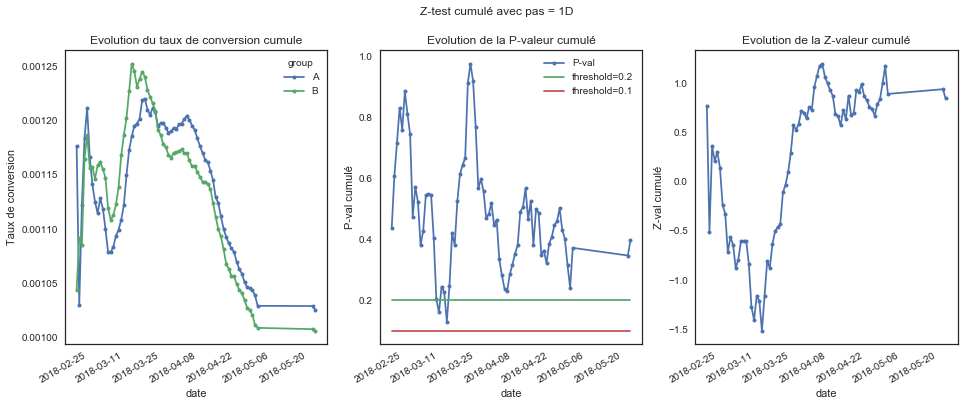

In [9]:
freq = "1D"
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Les résultats du Z test sont  différents en fonction de l'instant considéré : si on s'était arrêté vers début Mars on aurait pu rejeter H0 avec un taux de confiance de 20% et dire que B est meilleur. Mais, dans tous les cas, on est au-dessus de la p-valeur de 10% et quasiment tout le temps au-dessus de 20% :  il n'y a pas de variation de la significativité du test et on ne peut pas conclure pour ces niveaux de confiance que les deux versions sont différentes.

Est-ce que la réalisation du testZ cumulé avec un pas de plusieurs jours donnerait de meilleurs résultats ? On fait un test Z avec les données de t0 à t0 + pas, puis t0 à t0 + 2pas...

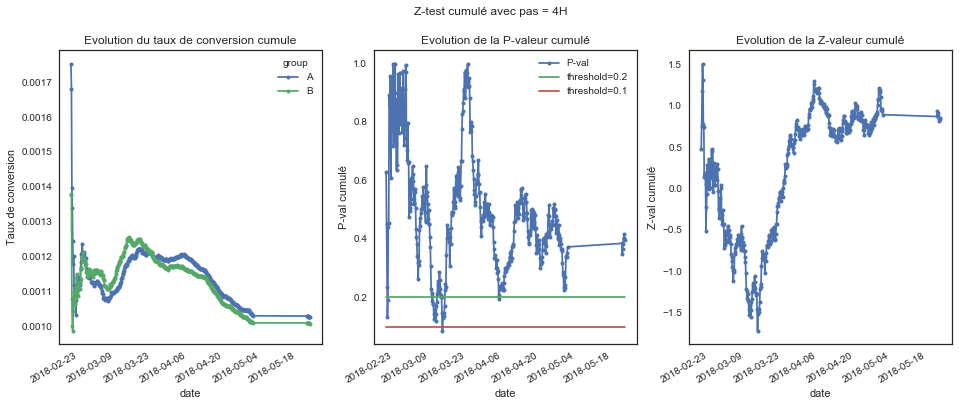

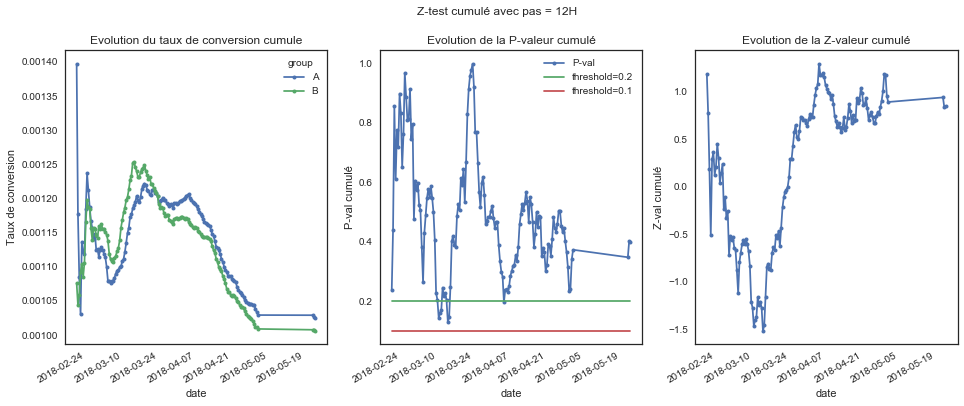

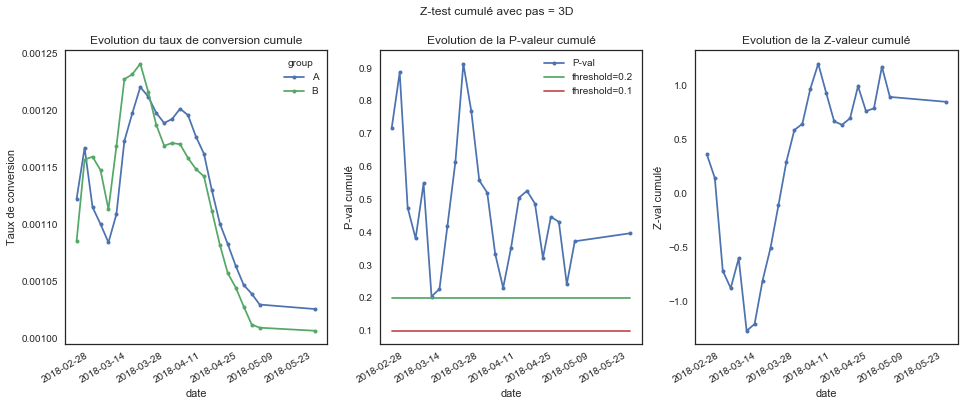

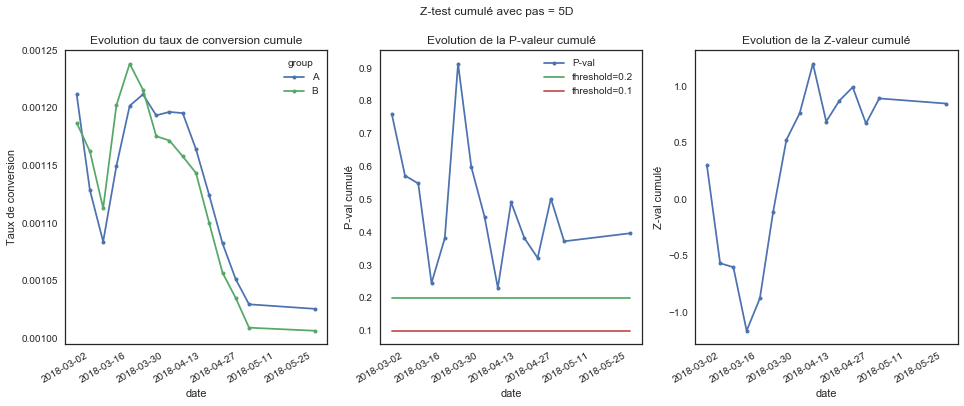

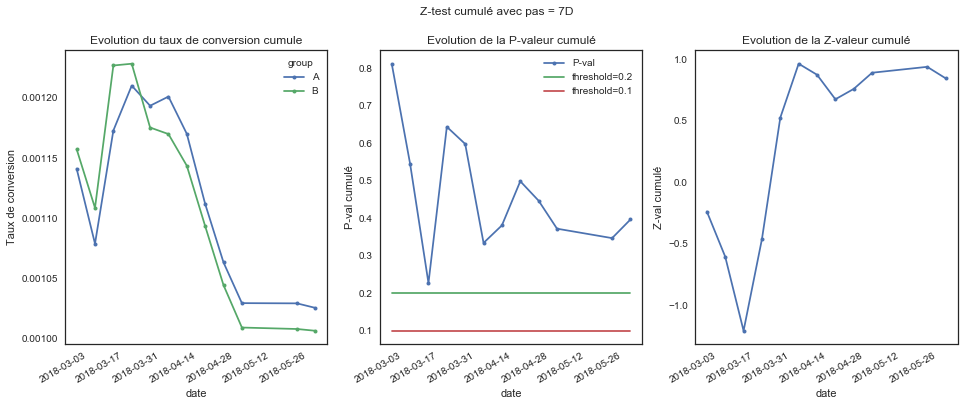

In [36]:
for freq in ["4H", "12H", "3D", "5D", "7D"]:  # 1W does not work but 7D is ok
    Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
    plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Conclusion : 

Avec des pas de 4H, 12H, 3, 5 et 7 jours, la conclusion reste la même, aucune version n'est meilleure.

# Stationnarité des taux de conversion

## Groupe A

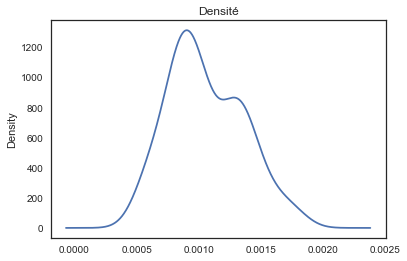

## Analyse classique d'une ST

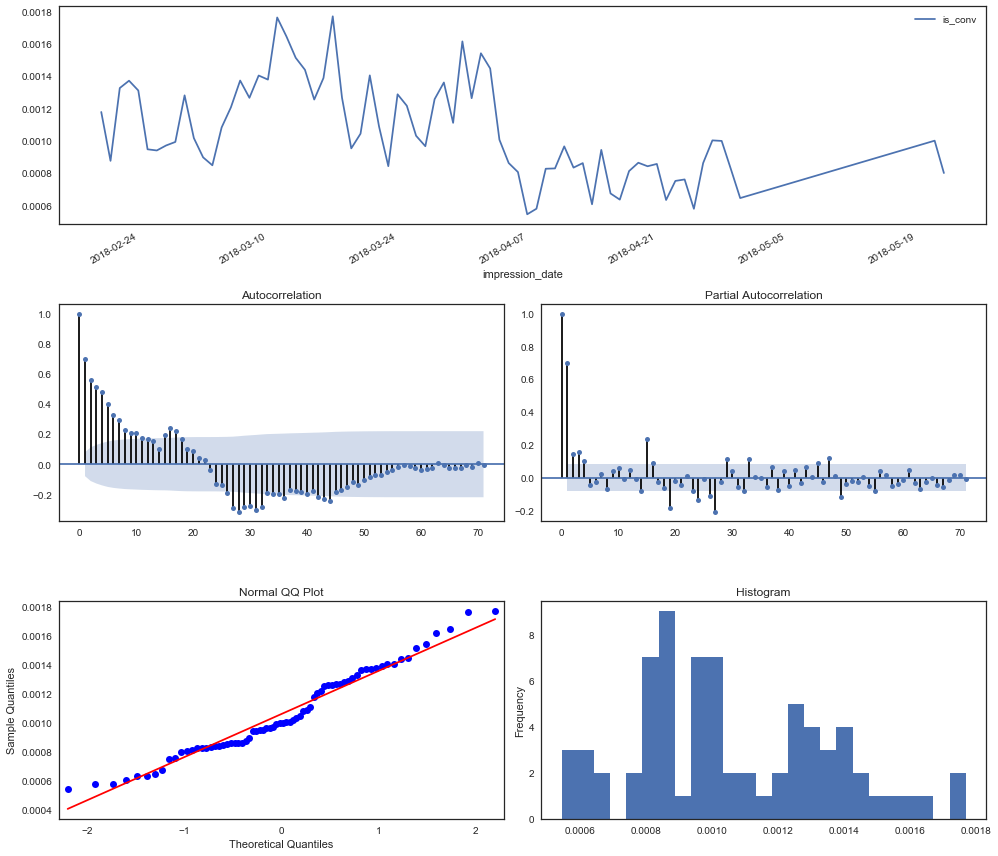

## Effet journalier

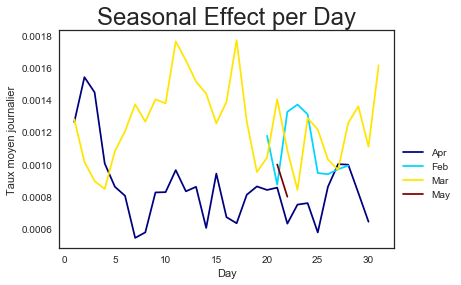

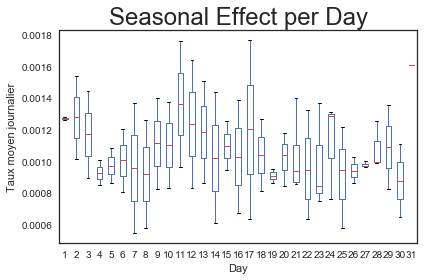

## Décomposition de la série de temps selon modèle multiplicatif

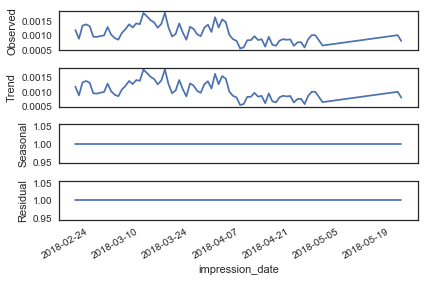

## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-2.044453
p-value,0.267428
# of lags,2.000000
# of observations,69.000000
Critical Value (1%),-3.528890
Critical Value (5%),-2.904440
Critical Value (10%),-2.589656


In [4]:
analyser(dataA)

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



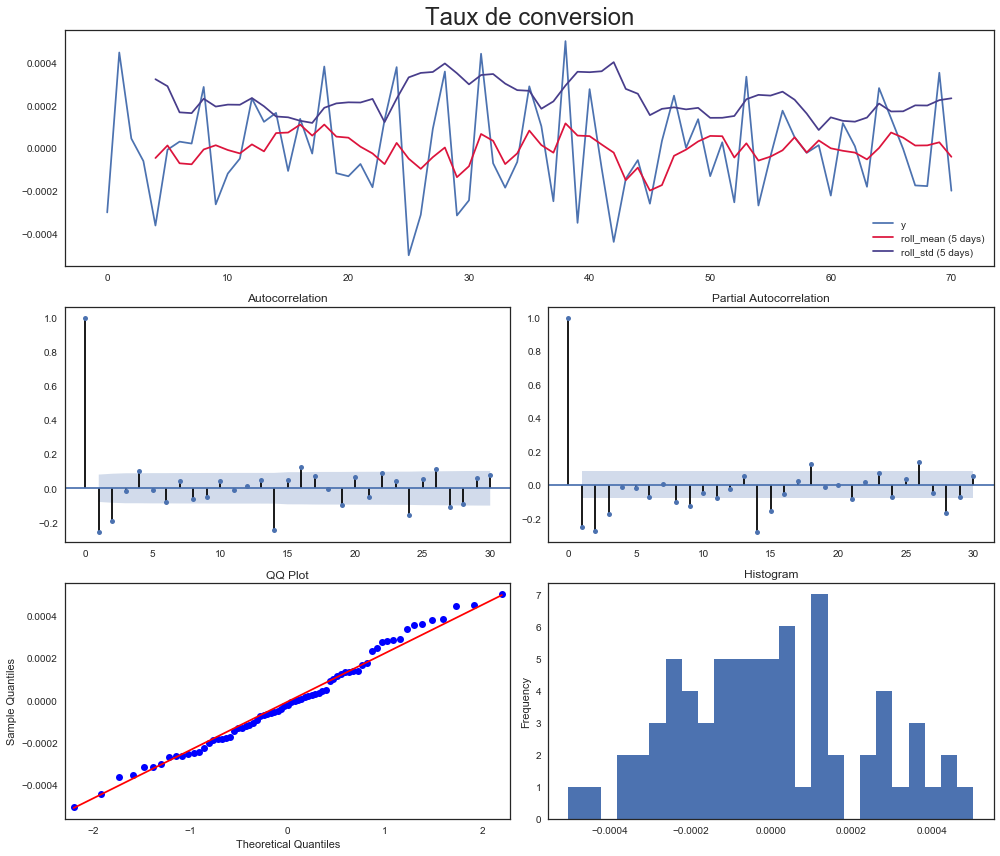

,Results of Augmented Dickey-Fuller test:
test statistic,-8.551155e+00
p-value,9.215552e-14
# of lags,1.000000e+00
# of observations,6.900000e+01
Critical Value (1%),-3.528890e+00
Critical Value (5%),-2.904440e+00
Critical Value (10%),-2.589656e+00


In [5]:
transformer(dataA,"diff1")

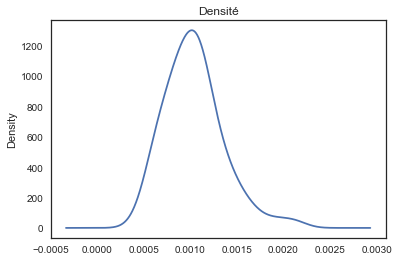

## Analyse classique d'une ST

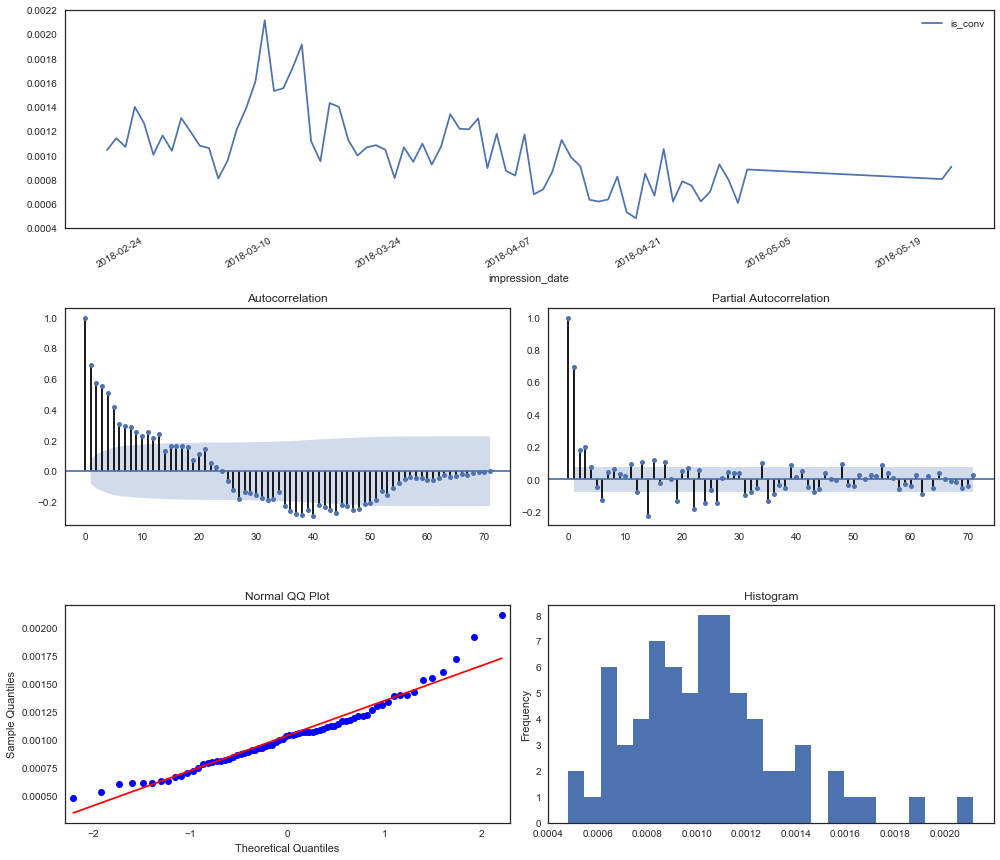

## Effet journalier

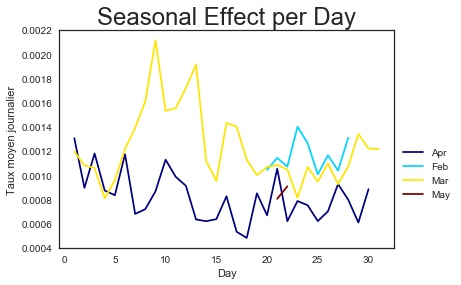

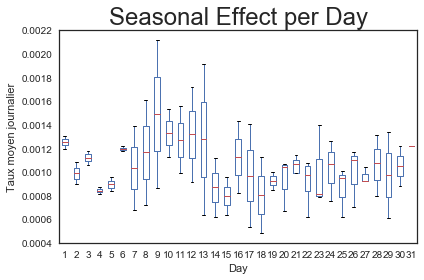

## Décomposition de la série de temps selon modèle multiplicatif

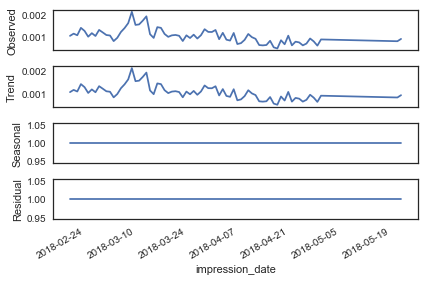

## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-1.984689
p-value,0.293326
# of lags,2.000000
# of observations,69.000000
Critical Value (1%),-3.528890
Critical Value (5%),-2.904440
Critical Value (10%),-2.589656


In [6]:
analyser(dataB)

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



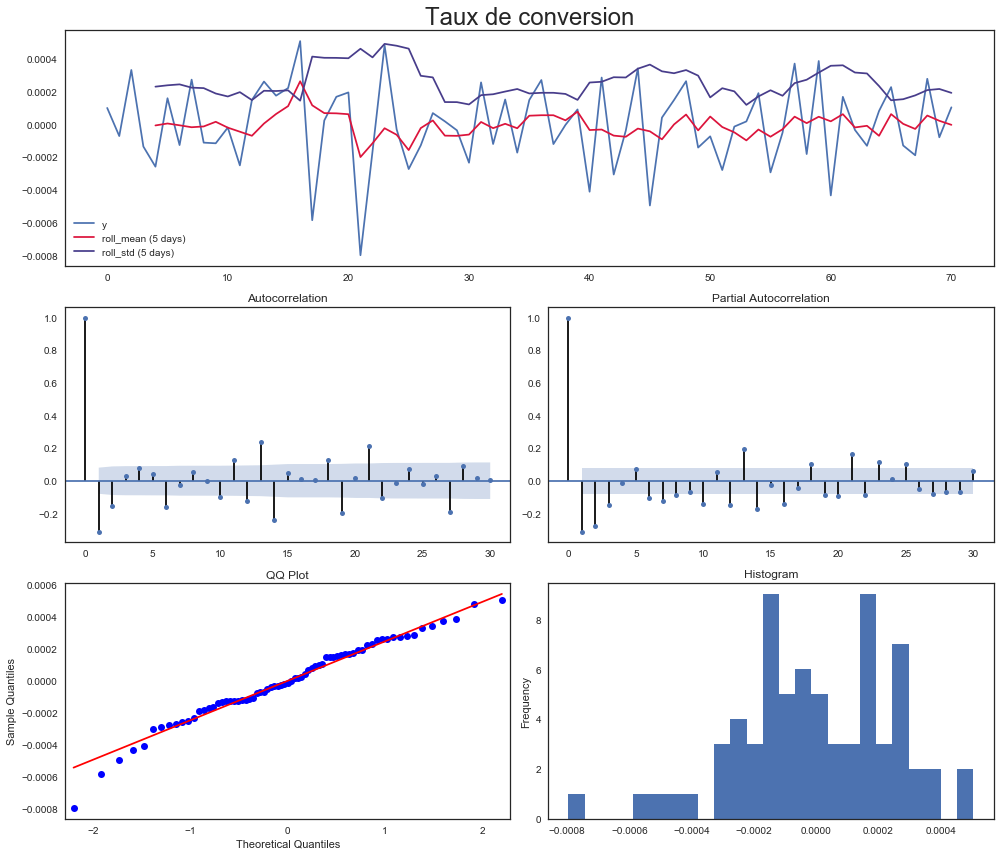

,Results of Augmented Dickey-Fuller test:
test statistic,-8.769649e+00
p-value,2.541419e-14
# of lags,1.000000e+00
# of observations,6.900000e+01
Critical Value (1%),-3.528890e+00
Critical Value (5%),-2.904440e+00
Critical Value (10%),-2.589656e+00


In [7]:
transformer(dataB,"diff1")

# Modèles ARMA

Afin de prédire la série des Z-valeurs ou celle des p-valeurs, dans cette partie, nous allons voir s'il est possible de trouver un modèle ARMA(p, q) correspondant bien à l'ensemble des données. Nous jugerons les performances via les critères AIC, BIC ainsi que sur les prévisions in-sample à partir de la moitié ou des 3/4 des données.

In [3]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')

### a. Etude sur Z

## Analyse classique d'une ST

/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


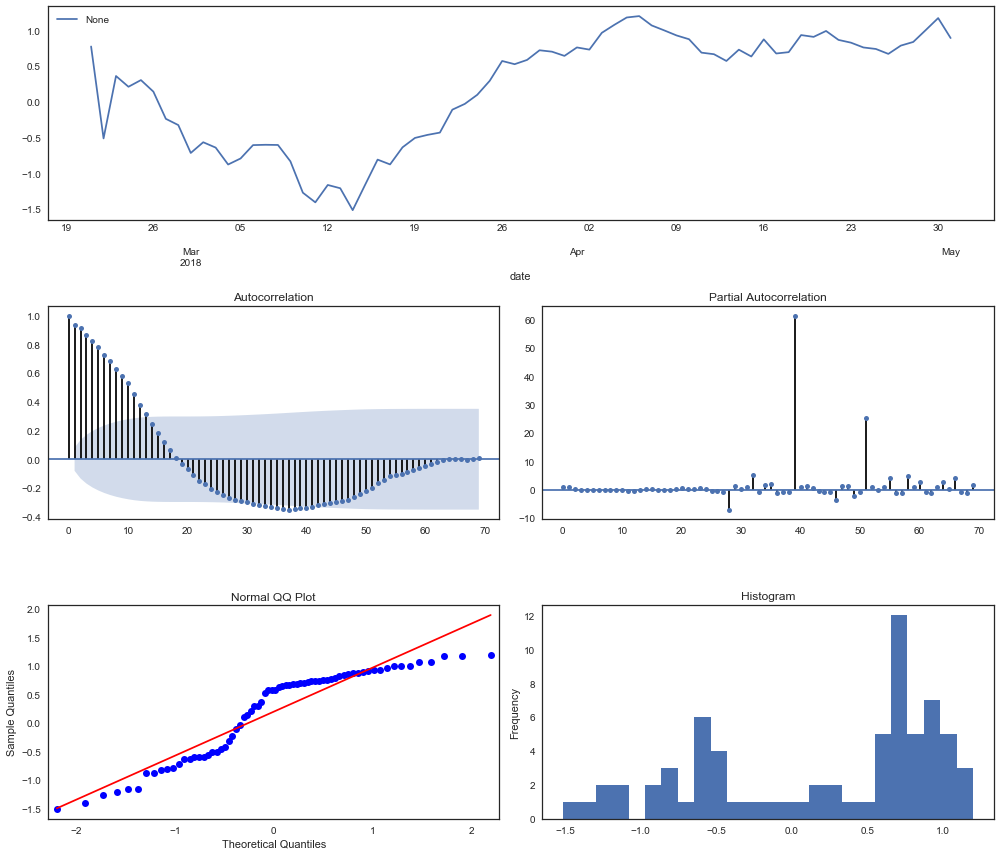

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-2.616787
p-value,0.089577
# of lags,11.000000
# of observations,58.000000
Critical Value (1%),-3.548494
Critical Value (5%),-2.912837
Critical Value (10%),-2.594129


In [4]:
series = Z_cum
analyserZP(series)

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow en

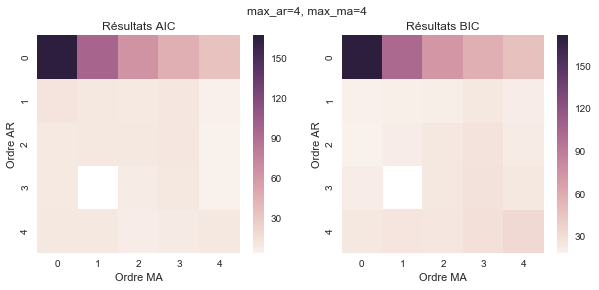

AIC meilleur modèle : AR=3, MA=4, AIC=4.184045460365525 
BIC meilleur modèle : AR=2, MA=0, BIC=18.455167391463224 


In [5]:
##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(3, 4)   Log Likelihood                   6.908
Method:                       css-mle   S.D. of innovations              0.198
Date:                Mon, 04 Feb 2019   AIC                              4.184
Time:                        21:49:21   BIC                             24.421
Sample:                             0   HQIC                            12.222
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3069      0.394      0.780      0.438      -0.464       1.078
ar.L1.y        0.6069      0.132      4.607      0.000       0.349       0.865
ar.L2.y       -0.0320      0.187     -0.171      0.8

## Erreurs sur la période d'entraînement

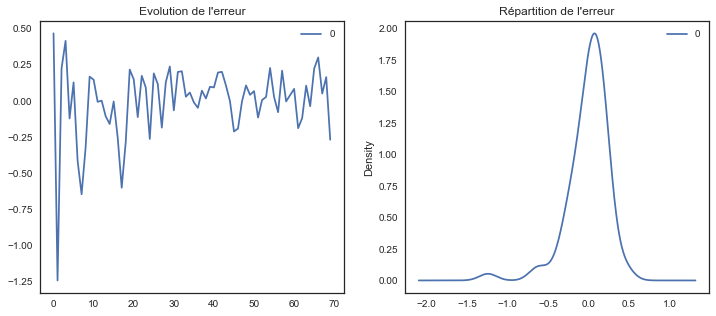

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(2, 0)   Log Likelihood                  -0.731
Method:                       css-mle   S.D. of innovations              0.241
Date:                Mon, 04 Feb 2019   AIC                              9.461
Time:                        21:49:21   BIC                             18.455
Sample:                             0   HQIC                            13.034
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4272      0.491      0.871      0.387      -0.534       1.389
ar.L1.y        0.6187      0.143      4.319      0.000       0.338       0.900
ar.L2.y        0.3372      0.145      2.326      0.0

## Erreurs sur la période d'entraînement

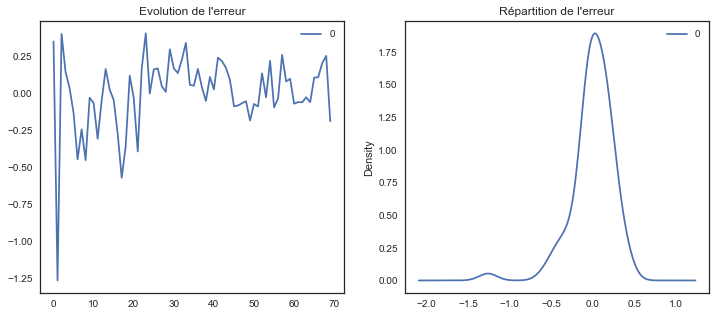

In [6]:
display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)

### Zoom sur un modèle en particulier

Pour un modèle donné, est-ce que ce modèle est pertinent ? Regarder les p-valeurs des coefficients. 

Dans cette section on a construit le modèle à partir de l'ensemble des données. Mais quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées
    + C'est ce mode qui nous intéresse car on aimerait faire des prédictions pour des horizons lointains sans avoir à faire le test A/B en réel

train_ratio= 0.25


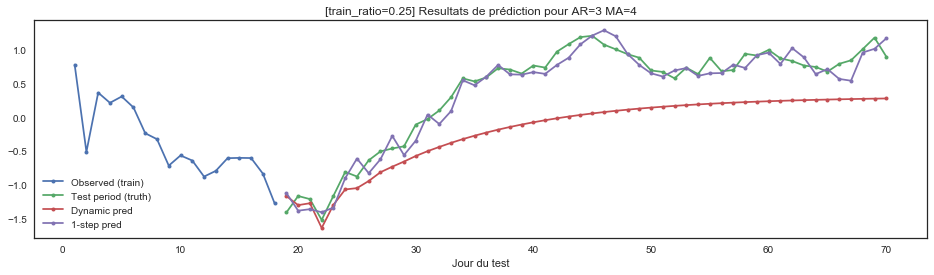

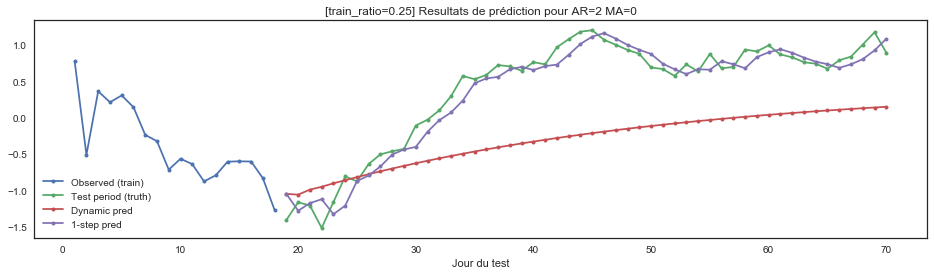

train_ratio= 0.5


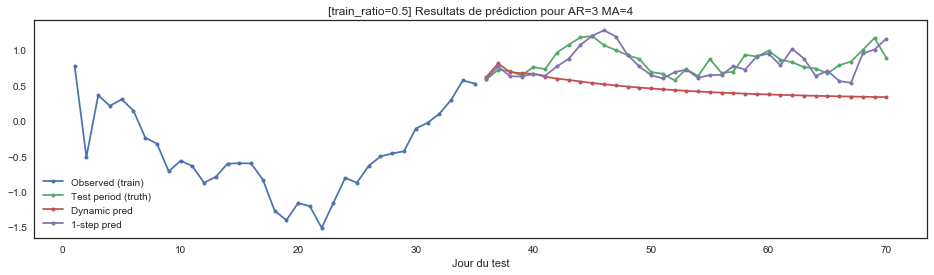

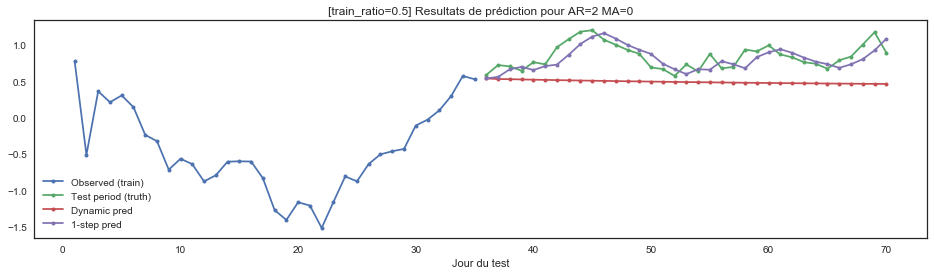

train_ratio= 0.75


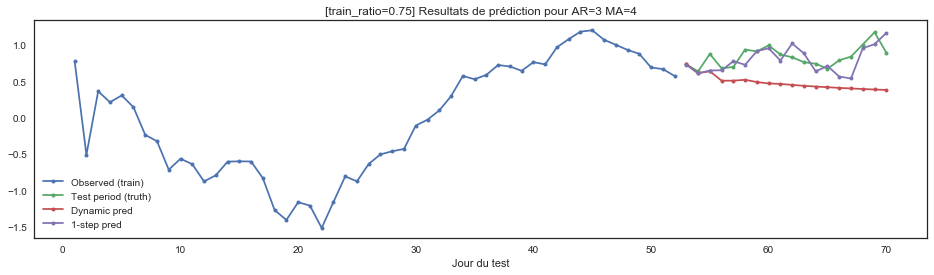

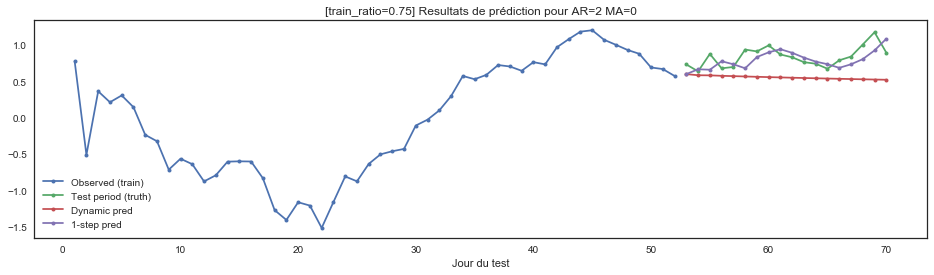

In [7]:
for train_ratio in [0.25, 0.5, 0.75]:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:    
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)

> Dans l'ensemble, les prévisions dynamiques peuvent capturer une partie des fluctuations des données, mais c'est pas terrible non plus. Il reste à savoir à quel point cela est exploitable, car ici on a pris toutes les données pour entraîner le modèle, incluant celles de la période test, on est en quelque sorte en train d'étudier la borne supérieure de la performance du modèle.

### b. Etude sur p

## Analyse classique d'une ST

/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


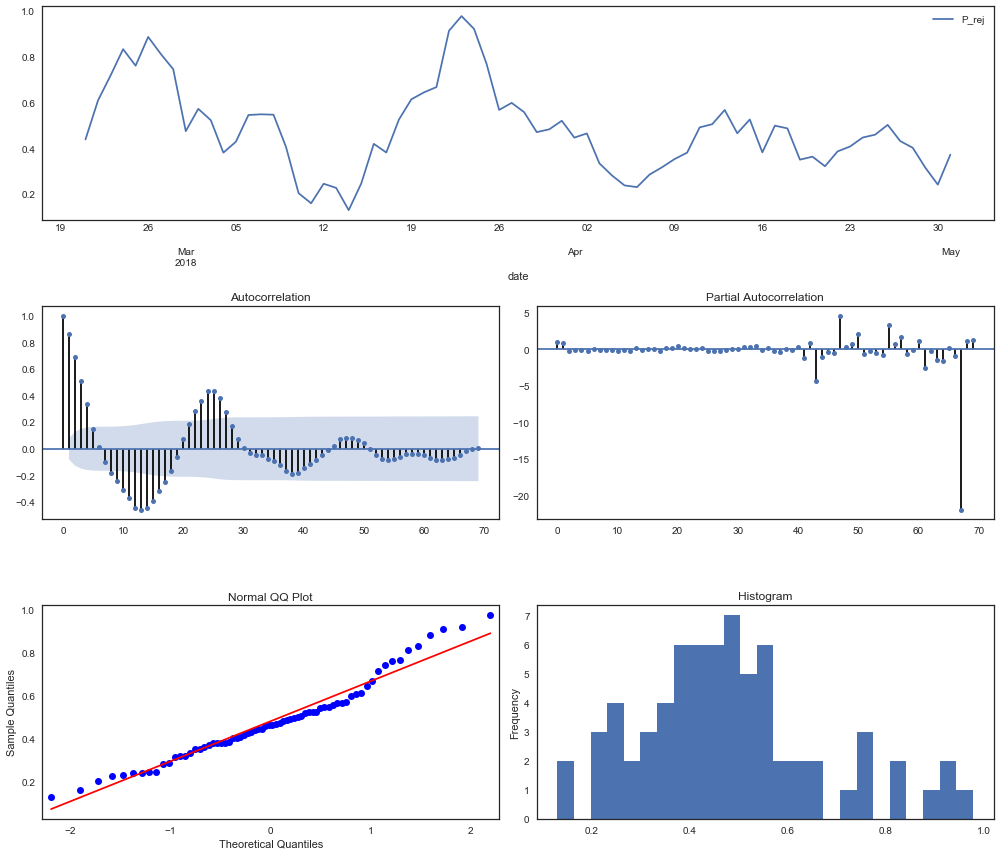

## Décomposition de la série de temps selon modèle multiplicatif

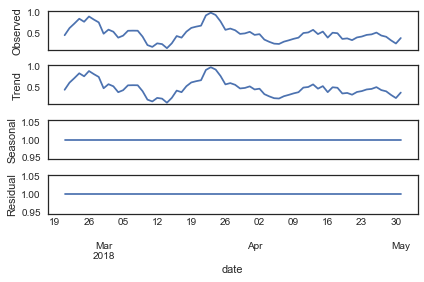

## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-2.563660
p-value,0.100743
# of lags,1.000000
# of observations,68.000000
Critical Value (1%),-3.530399
Critical Value (5%),-2.905087
Critical Value (10%),-2.590001


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packa

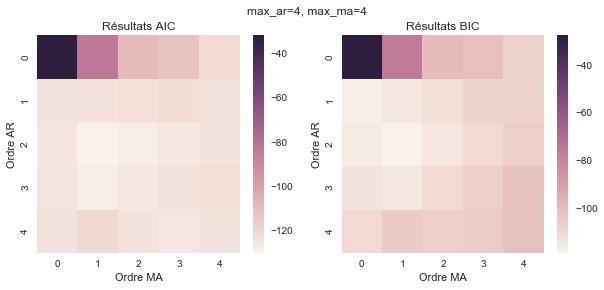

AIC meilleur modèle : AR=2, MA=1, AIC=-130.31727900113026 
BIC meilleur modèle : AR=2, MA=1, BIC=-119.07480279088347 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   70
Model:                     ARMA(2, 1)   Log Likelihood                  70.159
Method:                       css-mle   S.D. of innovations              0.087
Date:                Mon, 04 Feb 2019   AIC                           -130.317
Time:                        21:50:54   BIC                           -119.075
Sample:                             0   HQIC                          -125.852
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4727      0.018     26.388      0.000       0.438       0.508
ar.L1.y        1.8251      0.071     25.570      0.000       1.685       1.965
ar.L2.y       -0.8835      0.062    -14.251      0.0

## Erreurs sur la période d'entraînement

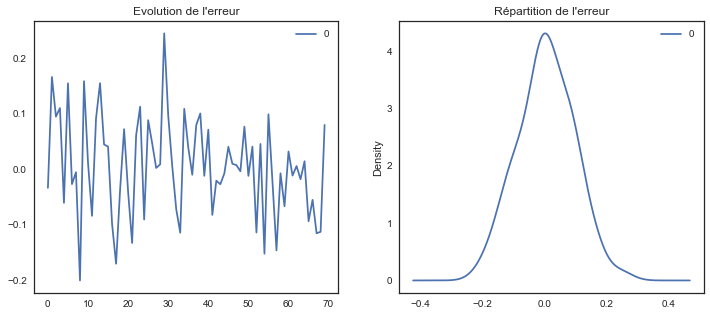

train_ratio= 0.25


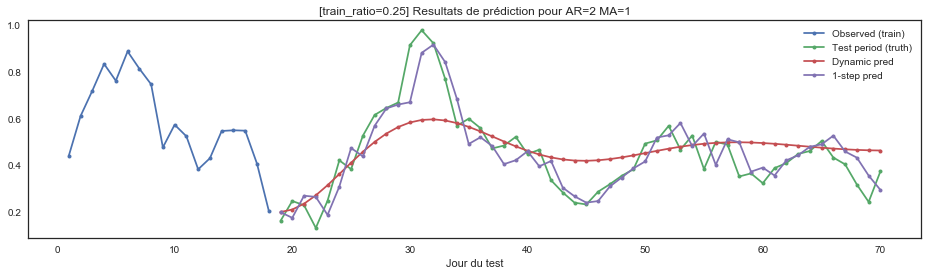

train_ratio= 0.5


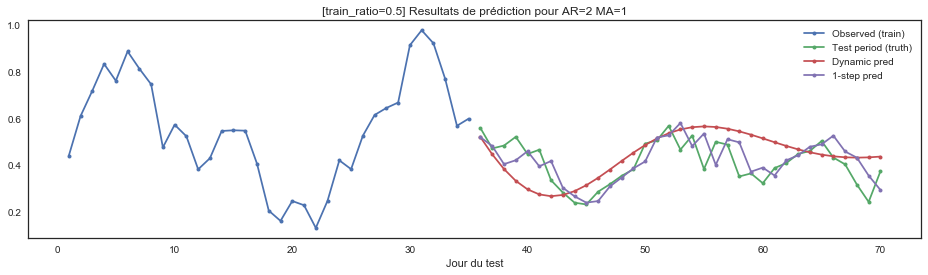

train_ratio= 0.75


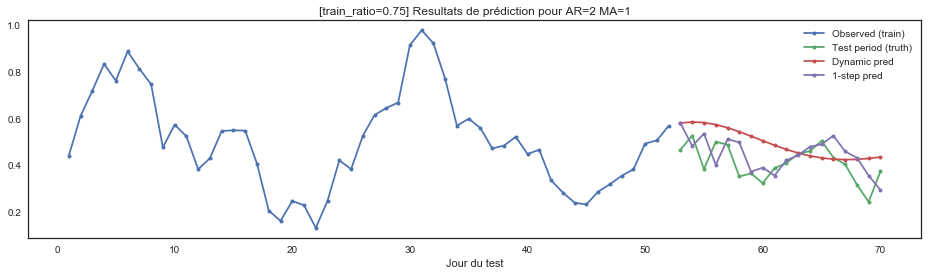

In [8]:
series = P_rej
analyserZP(series)

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
train_ratio_list = [0.25, 0.5, 0.75]
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
for train_ratio in train_ratio_list:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)    

## Fit sur modèle tronqué

Si les résultats en fittant sur l'ensemble des données donnent des prévisions in-sample encore acceptables, nous nous intéressons aux prévisions out-of-sample à présent, si les résultats sont bons cela nous permettra de pouvoir arrêter les tests A/B plus tôt. Nous allons prendre 50% et 75% des données et observer la performance sur les modèles ARMA.

### train_ratio = 0.5

Si on entraîne sur la moitié des données (`train_ratio=0.5`), est-il possible d'avoir quand même un modèle permettant de prédire de manière convaincante la série des Z-valeurs ou des p-valeurs ?. 

In [9]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')
train_ratio = 0.5
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum.iloc[0:t]
P_tronq = P_rej.iloc[0:t]

#### a. Etude sur Z

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6

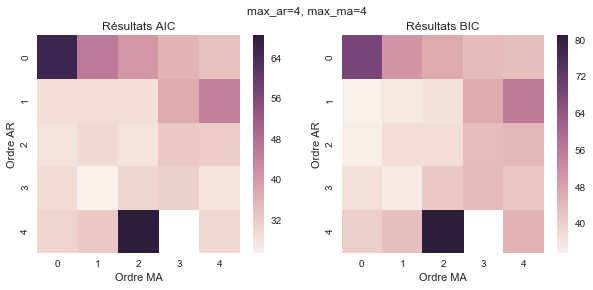

AIC meilleur modèle : AR=3, MA=1, AIC=25.42019761834787 
BIC meilleur modèle : AR=1, MA=0, BIC=33.56490000068339 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   35
Model:                     ARMA(3, 1)   Log Likelihood                  -6.710
Method:                       css-mle   S.D. of innovations              0.275
Date:                Mon, 04 Feb 2019   AIC                             25.420
Time:                        21:51:42   BIC                             34.752
Sample:                             0   HQIC                            28.642
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3773      0.183     -2.060      0.048      -0.736      -0.018
ar.L1.y        1.3130      0.196      6.703      0.000       0.929       1.697
ar.L2.y        0.2323      0.378      0.615      0.5

## Erreurs sur la période d'entraînement

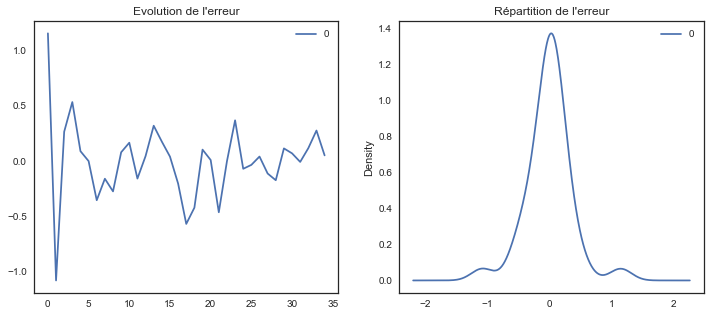

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   35
Model:                     ARMA(1, 0)   Log Likelihood                 -11.449
Method:                       css-mle   S.D. of innovations              0.329
Date:                Mon, 04 Feb 2019   AIC                             28.899
Time:                        21:51:43   BIC                             33.565
Sample:                             0   HQIC                            30.510
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1249      0.425     -0.294      0.771      -0.959       0.709
ar.L1.y        0.8785      0.086     10.229      0.000       0.710       1.047
                                    Roots           

## Erreurs sur la période d'entraînement

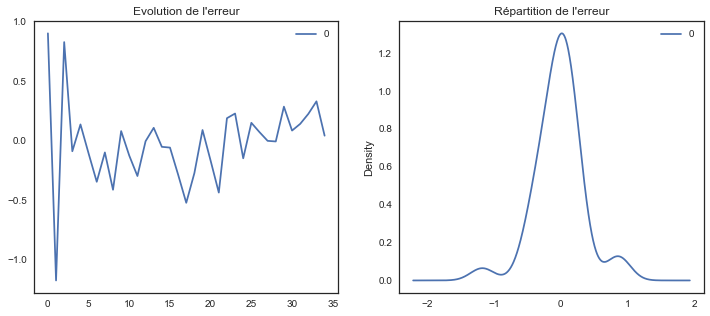

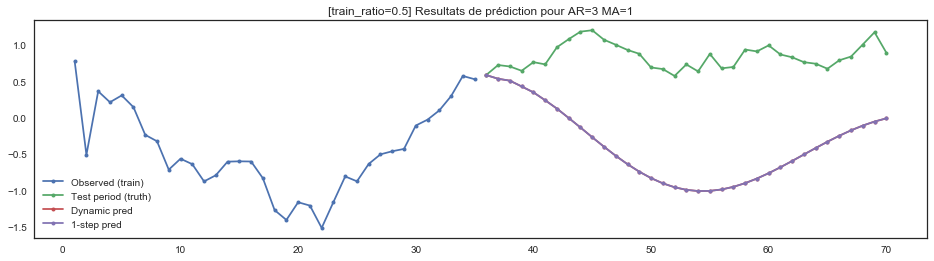

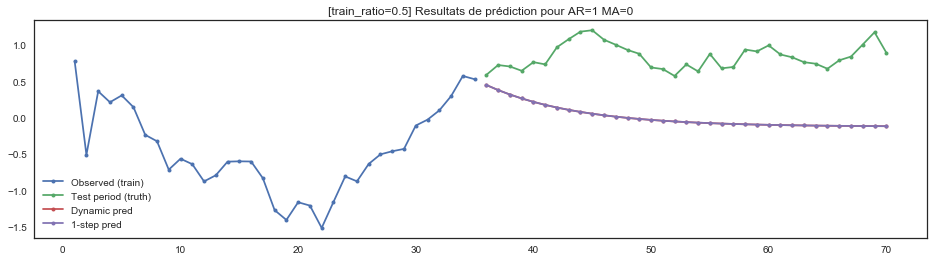

In [10]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/ts

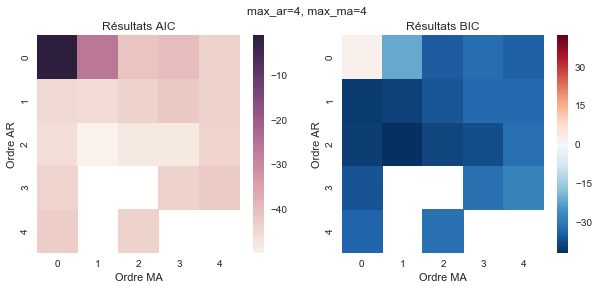

AIC meilleur modèle : AR=2, MA=1, AIC=-49.8149614657824 
BIC meilleur modèle : AR=2, MA=1, BIC=-42.03822115833533 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   35
Model:                     ARMA(2, 1)   Log Likelihood                  29.907
Method:                       css-mle   S.D. of innovations              0.097
Date:                Mon, 04 Feb 2019   AIC                            -49.815
Time:                        21:52:20   BIC                            -42.038
Sample:                             0   HQIC                           -47.130
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4975      0.021     23.506      0.000       0.456       0.539
ar.L1.y        1.8256      0.062     29.641      0.000       1.705       1.946
ar.L2.y       -0.9053      0.065    -13.904      0.0

## Erreurs sur la période d'entraînement

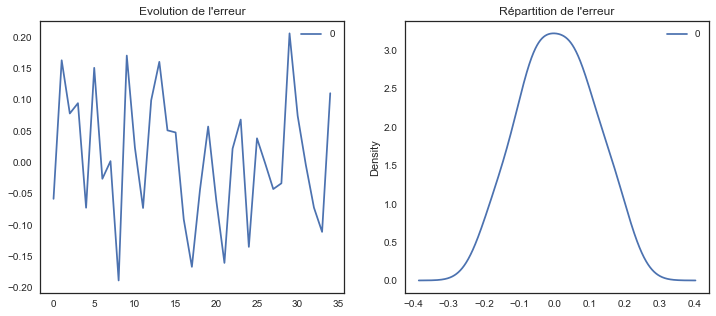

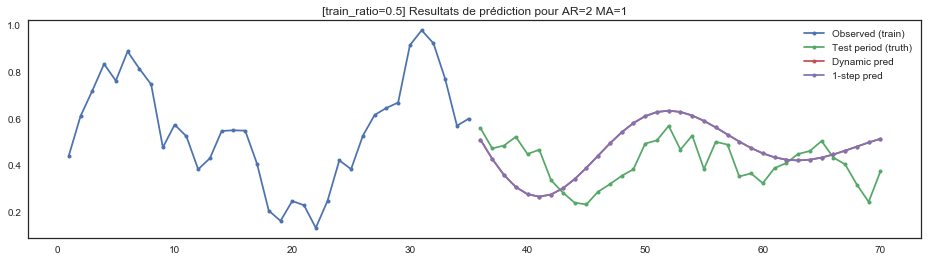

In [11]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)

### train_ratio = 0.75
On entraîne sur 75% des données (`train_ratio=0.75`). 

In [12]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')
train_ratio = 0.75
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum[0:t]
P_tronq = P_rej[0:t]

#### a. Etude sur Z

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow en

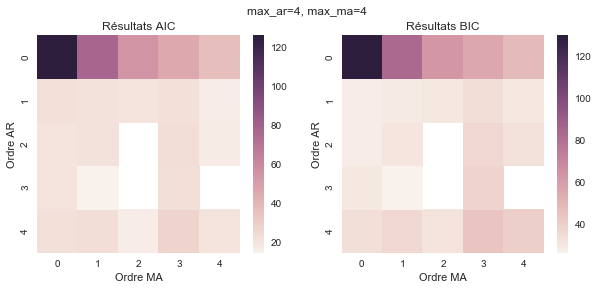

AIC meilleur modèle : AR=3, MA=1, AIC=14.59493336470419 
BIC meilleur modèle : AR=3, MA=1, BIC=26.302395676192756 


# Meilleur modèle selon AIC

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [19]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

> Ici il y a une erreur pourtant c'est censé être le meilleur résultat en terme d'AIC / BIC ?

#### b. Etude sur p

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/ts

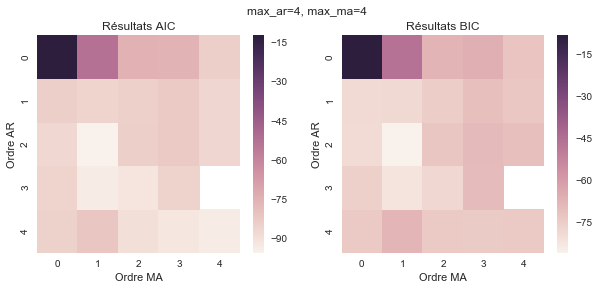

AIC meilleur modèle : AR=2, MA=1, AIC=-95.6066590759321 
BIC meilleur modèle : AR=2, MA=1, BIC=-85.85044048302495 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   52
Model:                     ARMA(2, 1)   Log Likelihood                  52.803
Method:                       css-mle   S.D. of innovations              0.084
Date:                Mon, 04 Feb 2019   AIC                            -95.607
Time:                        21:55:47   BIC                            -85.850
Sample:                             0   HQIC                           -91.866
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5009      0.010     48.546      0.000       0.481       0.521
ar.L1.y        1.8372      0.049     37.563      0.000       1.741       1.933
ar.L2.y       -0.9090      0.050    -18.224      0.0

## Erreurs sur la période d'entraînement

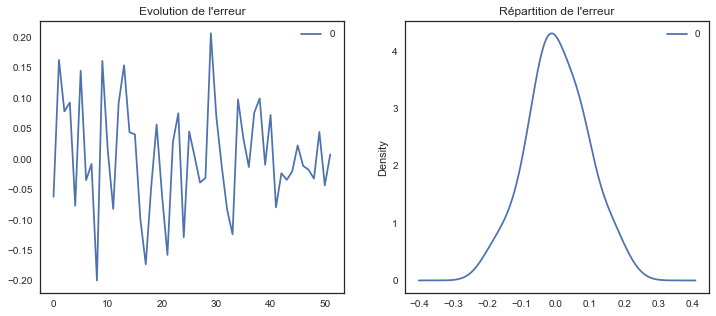

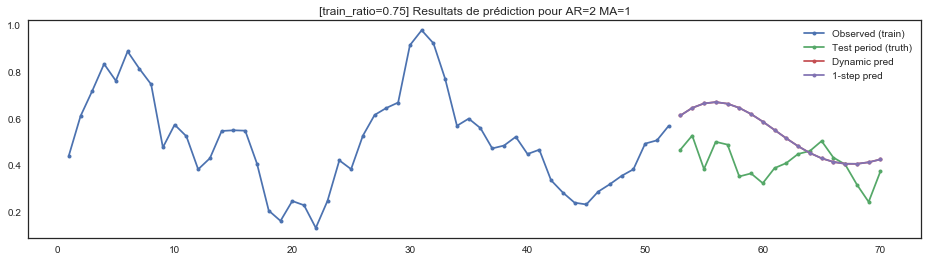

In [18]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)

> Visuellement, les résultats sur P sont intéressant. Après selon les prévisions on ne descend pas en-dessous de 0.2 ou 0.1 ce qui correspond à la réalité et n'affectera donc pas la conclusion du test A/B, qui sont qu'on ne peut pas conclure.